In [76]:
import os
import sys

import numpy as np
import scipy.io

import sys
sys.path.append("../../dpc/")
from util.point_cloud import point_cloud_distance
from util.simple_dataset import Dataset3D
from util.app_config import config as app_config
from util.tools import partition_range, to_np_object
from util.quaternion import quaternion_rotate
from util.euler import ypr_from_campos

import torch
from torch.utils.tensorboard import SummaryWriter
from models import model_pc_to as model_pc
from util.system import setup_environment
from run.ShapeRecords import ShapeRecords

import pickle
import pdb

In [77]:
def compute_distance(cfg, source_np, target_np):
    """
    compute projection from source to target
    """
    num_parts = cfg.pc_eval_chamfer_num_parts
    partition = partition_range(source_np.shape[0], num_parts)
    min_dist_np = np.zeros((0,))
    idx_np = np.zeros((0,))
    source_pc = torch.from_numpy(source_np).cuda()
    target_pc = torch.from_numpy(target_np).cuda()
    for k in range(num_parts):
        r = partition[k, :]
        src = source_pc[r[0]:r[1]]
        _, min_dist, min_idx = point_cloud_distance(src, target_pc)
        min_dist_0_np = min_dist.cpu().numpy()
        idx_0_np = min_idx.cpu().numpy()
        min_dist_np = np.concatenate((min_dist_np, min_dist_0_np), axis=0)
        idx_np = np.concatenate((idx_np, idx_0_np), axis=0)

    return min_dist_np, idx_np

In [78]:
def get_group(pos,divs):
    scale = divs/2
    yaw, pitch, roll = ypr_from_campos(pos[0], pos[1], pos[2])
    yaw = yaw + np.pi
    # get everything from 0 to 2*pi
    yaw = yaw%(2*np.pi)+0.00000001
    pitch = pitch%(2*np.pi)+0.00000001
    roll = roll%(2*np.pi) + 0.00000001
    
    q1 = np.ceil(scale*yaw/np.pi)-1
    q2 = np.ceil(scale*pitch/np.pi)-1
    q3 = np.ceil(scale*roll/np.pi)-1
    
    return q1*np.square(divs)+q2*divs+q3

In [79]:
    cfg = app_config

    setup_environment(cfg)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_dir = cfg.checkpoint_dir

    split_name = "eval"
    dataset_folder = cfg.inp_dir
    
    dataset = ShapeRecords(dataset_folder, cfg, 'test')
    dataset_loader = torch.utils.data.DataLoader(dataset,
                                                 batch_size=cfg.batch_size, shuffle=cfg.shuffle_dataset,
                                                 num_workers=4, drop_last=True)
    
    

Initialized dataset test with size 1355


In [ ]:
    divs = 4
    cfg = app_config
    exp_dir = cfg.checkpoint_dir
    num_views = cfg.num_views
    eval_unsup = cfg.eval_unsupervised_shape
    dataset_folder = cfg.inp_dir

    gt_dir = os.path.join(cfg.gt_pc_dir, cfg.synth_set)

    save_pred_name = "{}_{}".format(cfg.save_predictions_dir, cfg.eval_split)
    save_dir = os.path.join(exp_dir, cfg.save_predictions_dir)

    if eval_unsup:
        reference_rotation = scipy.io.loadmat("{}/final_reference_rotation.mat".format(exp_dir))["rotation"]

    dataset = ShapeRecords(dataset_folder, cfg, 'test')

    if cfg.models_list:
        model_names = parse_lines(cfg.models_list)
    else:
        model_names = dataset.file_names
    num_models = len(model_names)

    # making groups for samples and views according to 8 groups of yaw, pitch, roll
    chamfer_dict = {}
    images_dict = {}
    all_images = np.zeros((0,128,128,3))
    chamfer_all = np.zeros((0,2))
    for j in range(np.power(divs, 3)):
        chamfer_dict[j] = np.zeros((0,2))
        images_dict[j] = np.zeros((0,128,128,3))

    for k in range(150):
        sample = dataset.__getitem__(k)

        print("{}/{}".format(k, num_models))
        print(model_names[k])

        gt_filename = "{}/{}.mat".format(gt_dir, model_names[k]).replace('_features.p', '')
        mat_filename = "{}/{}_pc.pkl".format(save_dir, model_names[k])

        if not os.path.isfile(gt_filename) or not os.path.isfile(mat_filename):
            continue

        with open(mat_filename, 'rb') as handle:
            data = pickle.load(handle)
        all_pcs = np.squeeze(data["points"])
        if "num_points" in data:
            all_pcs_nums = np.squeeze(data["num_points"])
            has_number = True
        else:
            has_number = False
        obj = scipy.io.loadmat(gt_filename)
        Vgt = obj["points"]

        for i in range(num_views):
            chamfer_dists_current = np.zeros((2), dtype=np.float64)

            pred = all_pcs[i, :, :]
            if has_number:
                pred = pred[0:all_pcs_nums[i], :]

            if eval_unsup:
                pred = np.expand_dims(pred, 0)
                pred = quaternion_rotate(torch.from_numpy(pred).cuda(),
                                         torch.from_numpy(reference_rotation).cuda()).cpu().numpy()
                pred = np.squeeze(pred)

            pred_to_gt, idx_np = compute_distance(cfg, pred, Vgt)
            gt_to_pred, _ = compute_distance(cfg, Vgt, pred)
            chamfer_dists_current[0] = np.mean(pred_to_gt)
            chamfer_dists_current[1] = np.mean(gt_to_pred)

            is_nan = np.isnan(pred_to_gt)
            assert (not np.any(is_nan))

            campos = sample['cam_pos'][i]
            images = sample['image'][i].transpose(1,2,0)
            g = get_group(campos, divs)

            chamfer_dict[g] = np.concatenate((chamfer_dict[g], np.expand_dims(chamfer_dists_current, 0)))
            images_dict[g] = np.concatenate((images_dict[g], np.expand_dims(images,0)))
            all_images = np.concatenate((all_images, np.expand_dims(images,0)))
            chamfer_all = np.concatenate((chamfer_all, np.expand_dims(chamfer_dists_current, 0)))
            #print(i, ":", chamfer_dists_current)

        # current_mean = np.mean(chamfer_dists_current, 0)
        # print("total:", current_mean)        

### Obtain means of every cluster while grouping by Cam Pose

In [89]:
images_dict_cleaned = {}
chamfer_cleaned = {}
for k in images_dict.keys():
    if not images_dict[k].any():
        print("No objects grouped under group",k)
    else:
        images_dict_cleaned[k] = images_dict[k]
        chamfer_cleaned[k] = chamfer_dict[k]
chamfer_dict = chamfer_cleaned
images_dict = images_dict_cleaned
for key in chamfer_dict:
        print(key, np.mean(chamfer_dict[key],0)*100)

No objects grouped under group 1
No objects grouped under group 2
No objects grouped under group 3
No objects grouped under group 4
No objects grouped under group 5
No objects grouped under group 6
No objects grouped under group 7
No objects grouped under group 8
No objects grouped under group 9
No objects grouped under group 10
No objects grouped under group 11
No objects grouped under group 13
No objects grouped under group 14
No objects grouped under group 15
No objects grouped under group 17
No objects grouped under group 18
No objects grouped under group 19
No objects grouped under group 20
No objects grouped under group 21
No objects grouped under group 22
No objects grouped under group 23
No objects grouped under group 24
No objects grouped under group 25
No objects grouped under group 26
No objects grouped under group 27
No objects grouped under group 29
No objects grouped under group 30
No objects grouped under group 31
No objects grouped under group 33
No objects grouped unde

### Visualizing Groups

In [141]:
import matplotlib.pyplot as plt
import random
def display_nn_images(images, n, displ_str=None):
    samples = random.sample(range(0,images.shape[0]), min(n*n,images.shape[0]))
    f, axarr = plt.subplots(n,n)
    sample_idx = 0
    for i in range(n):
        for j in range(n):
            if sample_idx==len(samples):
                break
            axarr[i,j].imshow(images[samples[sample_idx]])
            sample_idx+=1
    plt.show()
    if displ_str is not None:
        print(displ_str)

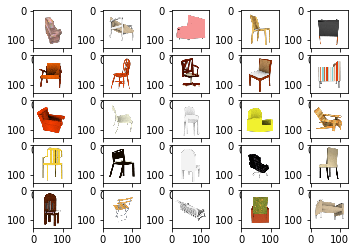

In [134]:
display_nn_images(all_images,5)

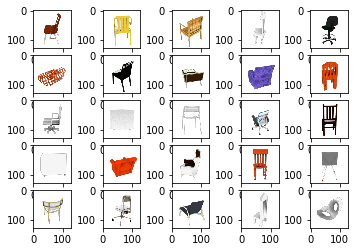

Group 0 Chamfer: [3.54687753 3.53891089]


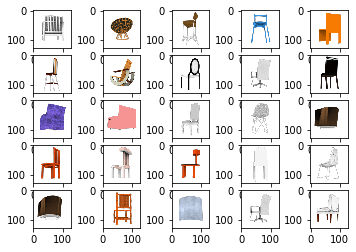

Group 12 Chamfer: [3.25617478 3.44554967]


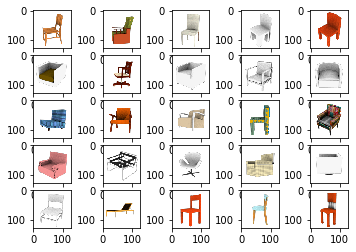

Group 16 Chamfer: [3.50709124 3.57510502]


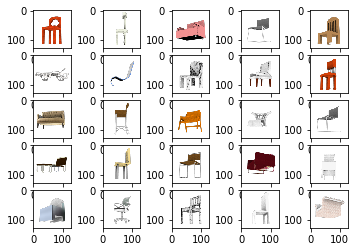

Group 28 Chamfer: [3.66830999 3.79809901]


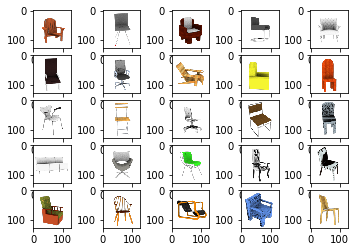

Group 32 Chamfer: [3.87755441 3.57910226]


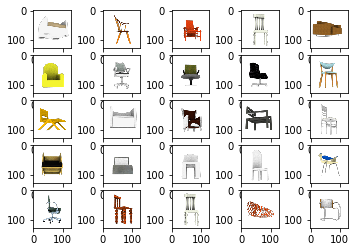

Group 44 Chamfer: [3.76342216 4.03180681]


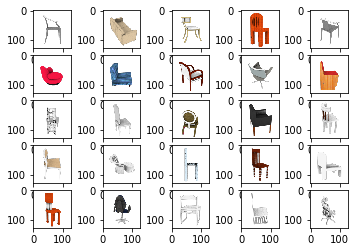

Group 48 Chamfer: [3.43532361 3.52720617]


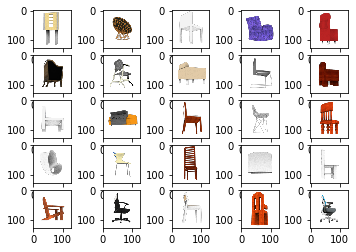

Group 60 Chamfer: [3.61176469 3.41246833]


In [135]:
for k in images_dict:
    displ_str = 'Group {} Chamfer: {}'.format(k,np.mean(chamfer_dict[k],0)*100)
    display_nn_images(images_dict[k],5, displ_str)

### PCA of all images

In [115]:
from sklearn.decomposition import PCA

In [120]:
images_val = all_images.reshape(all_images.shape[0],-1)
pca = PCA(50)
pca_image = pca.fit_transform(images_val)
pca_image = pca_image.reshape(-1,50)
print('Explained variance {}'.format(pca.explained_variance_ratio_.sum()))
all_images_pca = pca_image

0.7378414234742288


In [121]:
images_pca_dict = {}
for k in images_dict:
    print("Key:",k)
    images_val = images_dict[k].reshape(images_dict[k].shape[0],-1)
    pca = PCA(32)
    pca_image = pca.fit_transform(images_val)
    pca_image = pca_image.reshape(-1,32)
    print('Explained variance {}'.format(pca.explained_variance_ratio_.sum()))
    images_pca_dict[k] = pca_image


Key: 0
Explained variance 0.7483364071321792
Key: 12
Explained variance 0.8218495506881998
Key: 16
Explained variance 0.764373328552713
Key: 28
Explained variance 0.8303659151556766
Key: 32
Explained variance 0.7564979324931673
Key: 44
Explained variance 0.8304016409934556
Key: 48
Explained variance 0.7652541690601831
Key: 60
Explained variance 0.865780513386216


In [136]:
from sklearn.cluster import KMeans
n_clusters = 5

In [137]:
kmeans_all = KMeans(n_clusters=n_clusters,init='k-means++',random_state=0).fit(all_images_pca)

In [138]:
kmeans_dict = {}
for k in images_pca_dict:
    kmeans_dict[k] = KMeans(n_clusters=n_clusters,init='k-means++',random_state=0).fit(images_pca_dict[k])

(210, 128, 128, 3)


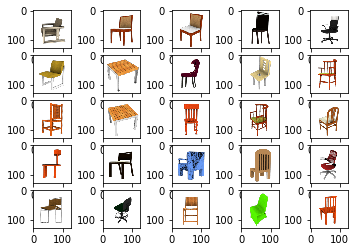

Chamfer Cluster 0: [2.8143329  2.72169388]
(174, 128, 128, 3)


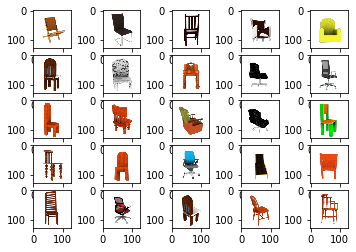

Chamfer Cluster 1: [3.03188471 2.9602063 ]
(577, 128, 128, 3)


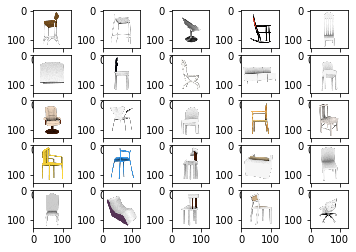

Chamfer Cluster 2: [3.35729258 3.28381823]
(199, 128, 128, 3)


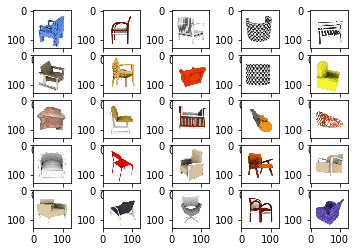

Chamfer Cluster 3: [5.29883935 5.5215485 ]
(90, 128, 128, 3)


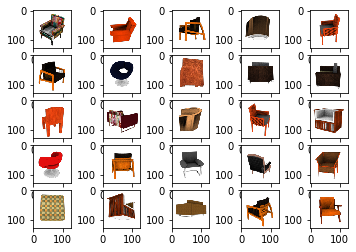

Chamfer Cluster 4: [4.07280472 4.5496134 ]


In [139]:
def chamfer_kmeans(kmeans, images_, chamfers_, n_cl,prepend='',n_displ=5):
    labels = kmeans.labels_
    for i in range(n_cl):
        mask = labels==i
        chamfers = chamfers_[mask]
        images = images_[mask]
        displ_str = prepend+'Chamfer Cluster {}: {}'.format(i,np.mean(chamfers,0)*100)
        print(images.shape)
        display_nn_images(images,n_displ, displ_str)
chamfer_kmeans(kmeans_all, all_images, chamfer_all,n_clusters)
    

(61, 128, 128, 3)


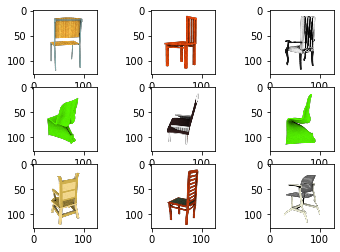

Group 0: Chamfer Cluster 0: [2.79770691 2.53557202]
(5, 128, 128, 3)


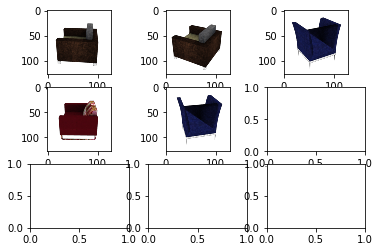

Group 0: Chamfer Cluster 1: [4.24343008 6.221499  ]
(46, 128, 128, 3)


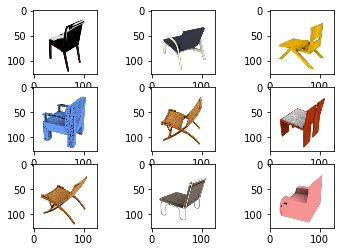

Group 0: Chamfer Cluster 2: [5.7034379 5.493265 ]
(24, 128, 128, 3)


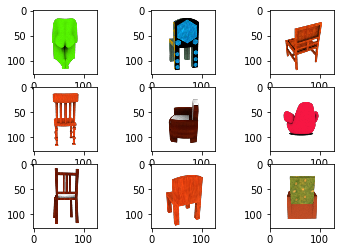

Group 0: Chamfer Cluster 3: [3.32060583 3.25134588]
(83, 128, 128, 3)


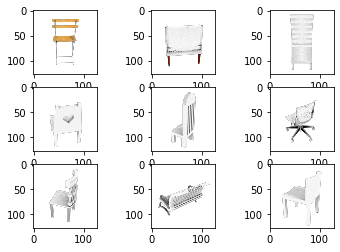

Group 0: Chamfer Cluster 4: [2.92573763 3.11471815]
(38, 128, 128, 3)


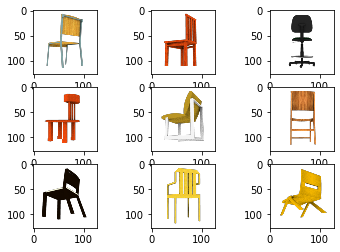

Group 12: Chamfer Cluster 0: [3.19889535 3.17053137]
(4, 128, 128, 3)


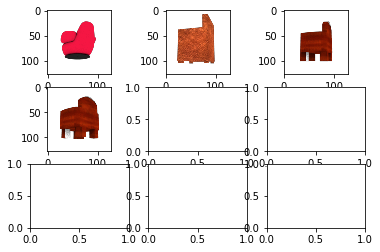

Group 12: Chamfer Cluster 1: [5.31138615 6.65756945]
(14, 128, 128, 3)


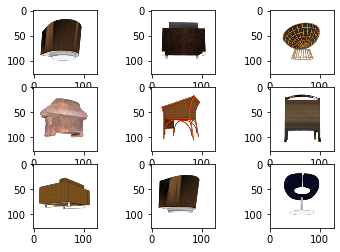

Group 12: Chamfer Cluster 2: [4.13917249 5.49468306]
(47, 128, 128, 3)


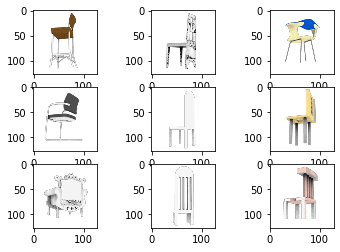

Group 12: Chamfer Cluster 3: [2.81603599 2.75175104]
(16, 128, 128, 3)


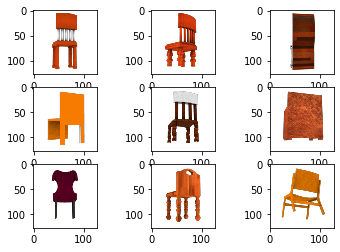

Group 12: Chamfer Cluster 4: [3.39869529 3.5407549 ]
(50, 128, 128, 3)


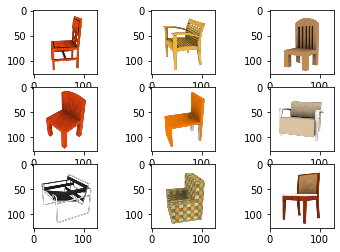

Group 16: Chamfer Cluster 0: [4.17811449 4.13731369]
(38, 128, 128, 3)


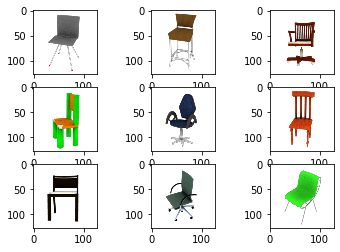

Group 16: Chamfer Cluster 1: [2.52379434 2.73813561]
(86, 128, 128, 3)


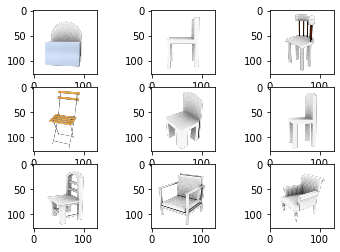

Group 16: Chamfer Cluster 2: [3.50804305 3.5112578 ]
(4, 128, 128, 3)


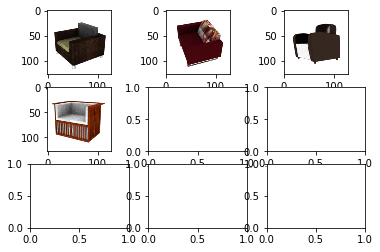

Group 16: Chamfer Cluster 3: [4.11975694 6.80675642]
(15, 128, 128, 3)


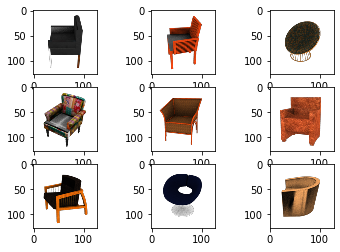

Group 16: Chamfer Cluster 4: [3.59253127 3.32568235]
(26, 128, 128, 3)


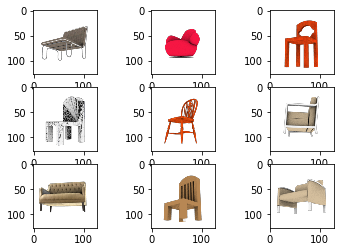

Group 28: Chamfer Cluster 0: [4.33294313 4.97968718]
(60, 128, 128, 3)


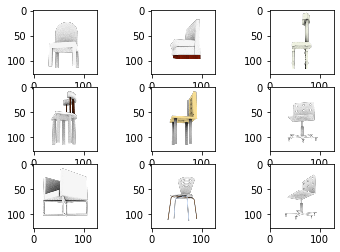

Group 28: Chamfer Cluster 1: [3.624488   3.60783906]
(9, 128, 128, 3)


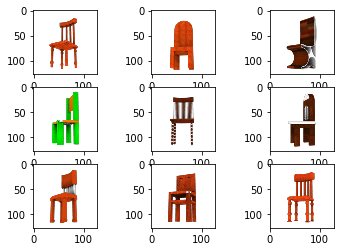

Group 28: Chamfer Cluster 2: [2.79781081 2.86895968]
(10, 128, 128, 3)


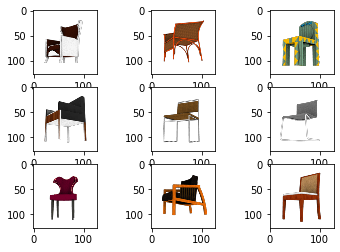

Group 28: Chamfer Cluster 3: [2.6237207  2.05909632]
(3, 128, 128, 3)


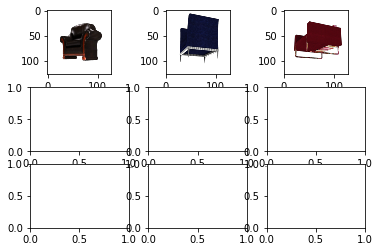

Group 28: Chamfer Cluster 4: [4.87805759 5.94696083]
(89, 128, 128, 3)


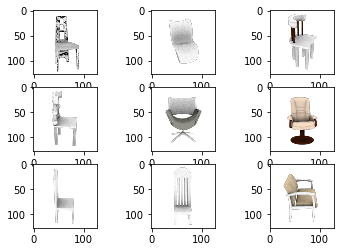

Group 32: Chamfer Cluster 0: [3.84242284 3.50447539]
(23, 128, 128, 3)


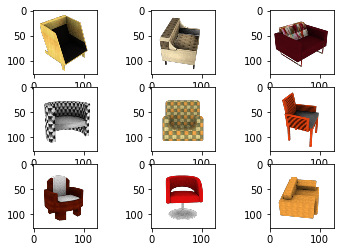

Group 32: Chamfer Cluster 1: [4.16388704 4.39257688]
(36, 128, 128, 3)


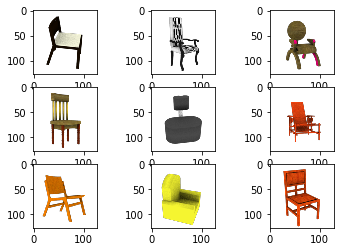

Group 32: Chamfer Cluster 2: [5.14348186 4.32911037]
(17, 128, 128, 3)


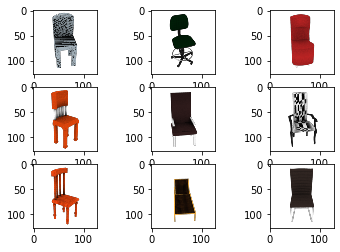

Group 32: Chamfer Cluster 3: [2.88142633 2.84475949]
(42, 128, 128, 3)


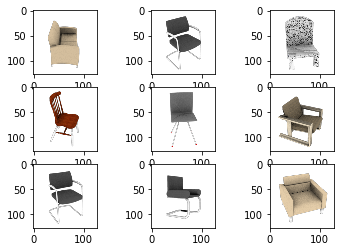

Group 32: Chamfer Cluster 4: [3.11331268 2.94613585]
(10, 128, 128, 3)


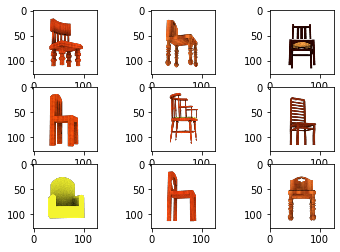

Group 44: Chamfer Cluster 0: [2.45565171 2.81727743]
(13, 128, 128, 3)


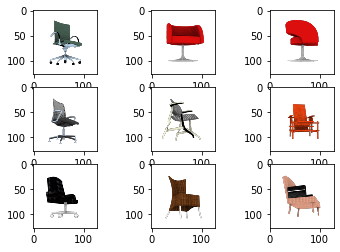

Group 44: Chamfer Cluster 1: [3.13597818 2.61676163]
(9, 128, 128, 3)


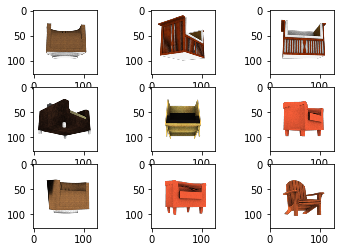

Group 44: Chamfer Cluster 2: [4.42245498 5.96168174]
(22, 128, 128, 3)


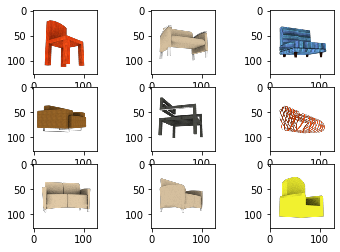

Group 44: Chamfer Cluster 3: [4.67715536 5.62794034]
(44, 128, 128, 3)


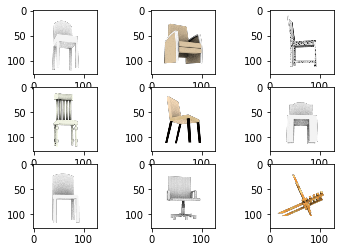

Group 44: Chamfer Cluster 4: [3.65435512 3.53310382]
(37, 128, 128, 3)


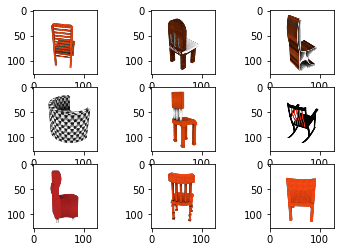

Group 48: Chamfer Cluster 0: [2.55958766 2.75710092]
(92, 128, 128, 3)


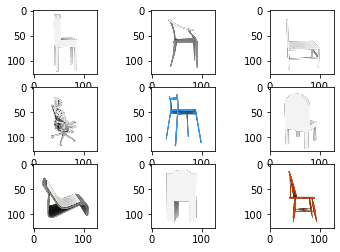

Group 48: Chamfer Cluster 1: [3.23304475 3.04128367]
(20, 128, 128, 3)


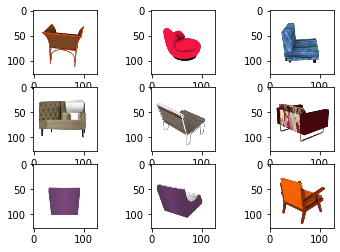

Group 48: Chamfer Cluster 2: [5.91384214 6.51018133]
(54, 128, 128, 3)


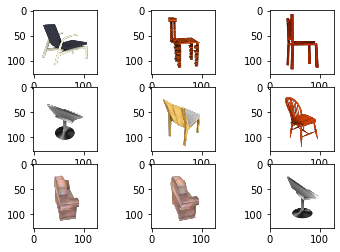

Group 48: Chamfer Cluster 3: [3.44652229 3.68425138]
(8, 128, 128, 3)


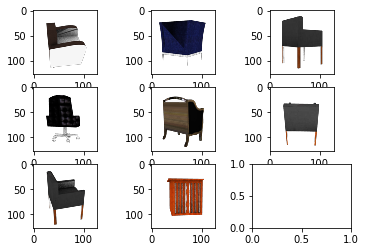

Group 48: Chamfer Cluster 4: [3.53992169 4.15955866]
(13, 128, 128, 3)


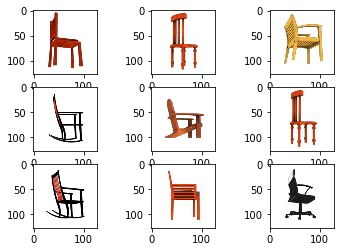

Group 60: Chamfer Cluster 0: [3.73218221 2.8608901 ]
(56, 128, 128, 3)


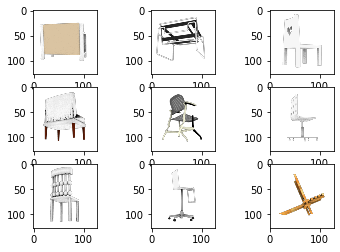

Group 60: Chamfer Cluster 1: [3.36913505 3.37343676]
(11, 128, 128, 3)


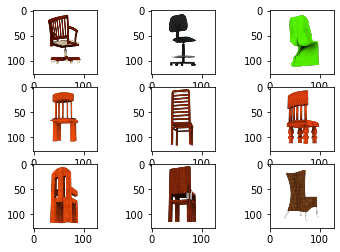

Group 60: Chamfer Cluster 2: [3.56452114 3.18761454]
(8, 128, 128, 3)


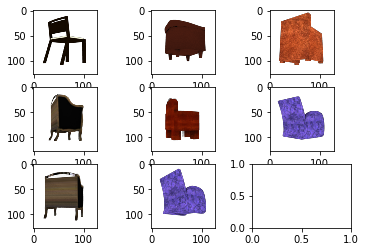

Group 60: Chamfer Cluster 3: [4.6680315  4.84565752]
(7, 128, 128, 3)


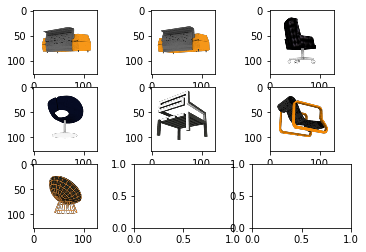

Group 60: Chamfer Cluster 4: [4.19624702 3.46449162]


In [142]:
for k in kmeans_dict:
    chamfer_kmeans(kmeans_dict[k], images_dict[k], chamfer_dict[k],n_clusters,'Group {}: '.format(k),n_displ=3)